Importing the libraries

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

Dataset load

In [27]:
data = pd.read_csv('football_goal_scorers.csv')

numeric_data = data.select_dtypes(include=['number'])

data['Height'] = data['Height'].apply(lambda x: int(x.split("'")[0]) * 12 + int(x.split("'")[1].replace('"', '')))
data.head()


Player Name       Nationality                          Club  \
0    Dustin Sanders  Marshall Islands   Small, Gregory and Mcdonald   
1     Scott Nielsen         Hong Kong                 Dudley-Spence   
2     Nathan Thomas       Saint Lucia             Martinez and Sons   
3  Edward Velasquez  Pitcairn Islands  Gibson, Mcfarland and Santos   
4        Kyle Woods            Israel                 Whitehead-Lee   

     Position  Goals Scored  Assists  Matches Played  Fouls per Match  \
0     Forward            33       14              33             3.14   
1    Defender            10        9              13             3.02   
2  Midfielder            18       19              11             0.64   
3  Midfielder             8       20              19             2.25   
4     Forward            16       13              16             0.94   

   Yellow Cards  Red Cards  ...  Age  Height  Total Shots  Expected Goals  \
0             7          1  ...   26      81           62            8.73   
1             3          3  ...   35      74           89           10.56   
2            15          2  ...   33      72           76            9.05   
3            11          0  ...   23      76           13           10.43   
4             7          1  ...   21      61           32           11.54   

   Shots on Target  Pass Accuracy  Free Kicks Scored  Penalties Scored  \
0               10          61.91                  0                10   
1               24          81.07                  1                 9   
2                7          75.56                  4                 1   
3               28          94.23                  1                 7   
4               39          66.36                  5                 2   

   Headers Scored  Own Goals  
0              10          4  
1               6          0  
2               5          2  
3               2          2  
4              11          3  

[5 rows x 21 columns]

Data Processing

In [28]:
X = data.drop('Goals Scored', axis=1)
y = data['Goals Scored']

# Perform one-hot encoding on categorical columns
categorical_cols = ['Player Name', 'Nationality', 'Club', 'Position']
encoder = OneHotEncoder(sparse=False)

X_encoded = encoder.fit_transform(X[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_encoded = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)


X_final = pd.concat([X.drop(categorical_cols, axis=1), X_encoded], axis=1)
print(X_final,y)

    Assists  Matches Played  Fouls per Match  Yellow Cards  Red Cards  \
0        14              33             3.14             7          1   
1         9              13             3.02             3          3   
2        19              11             0.64            15          2   
3        20              19             2.25            11          0   
4        13              16             0.94             7          1   
..      ...             ...              ...           ...        ...   
95        8              12             0.10             4          1   
96        0              29             1.59             3          3   
97        8              38             3.11             3          0   
98       17              28             1.29             0          1   
99        5              34             1.18             7          2   

    Minutes Played  Age  Height  Total Shots  Expected Goals  ...  \
0             2712   26      81           62          

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pairplot and Correlation heatmap

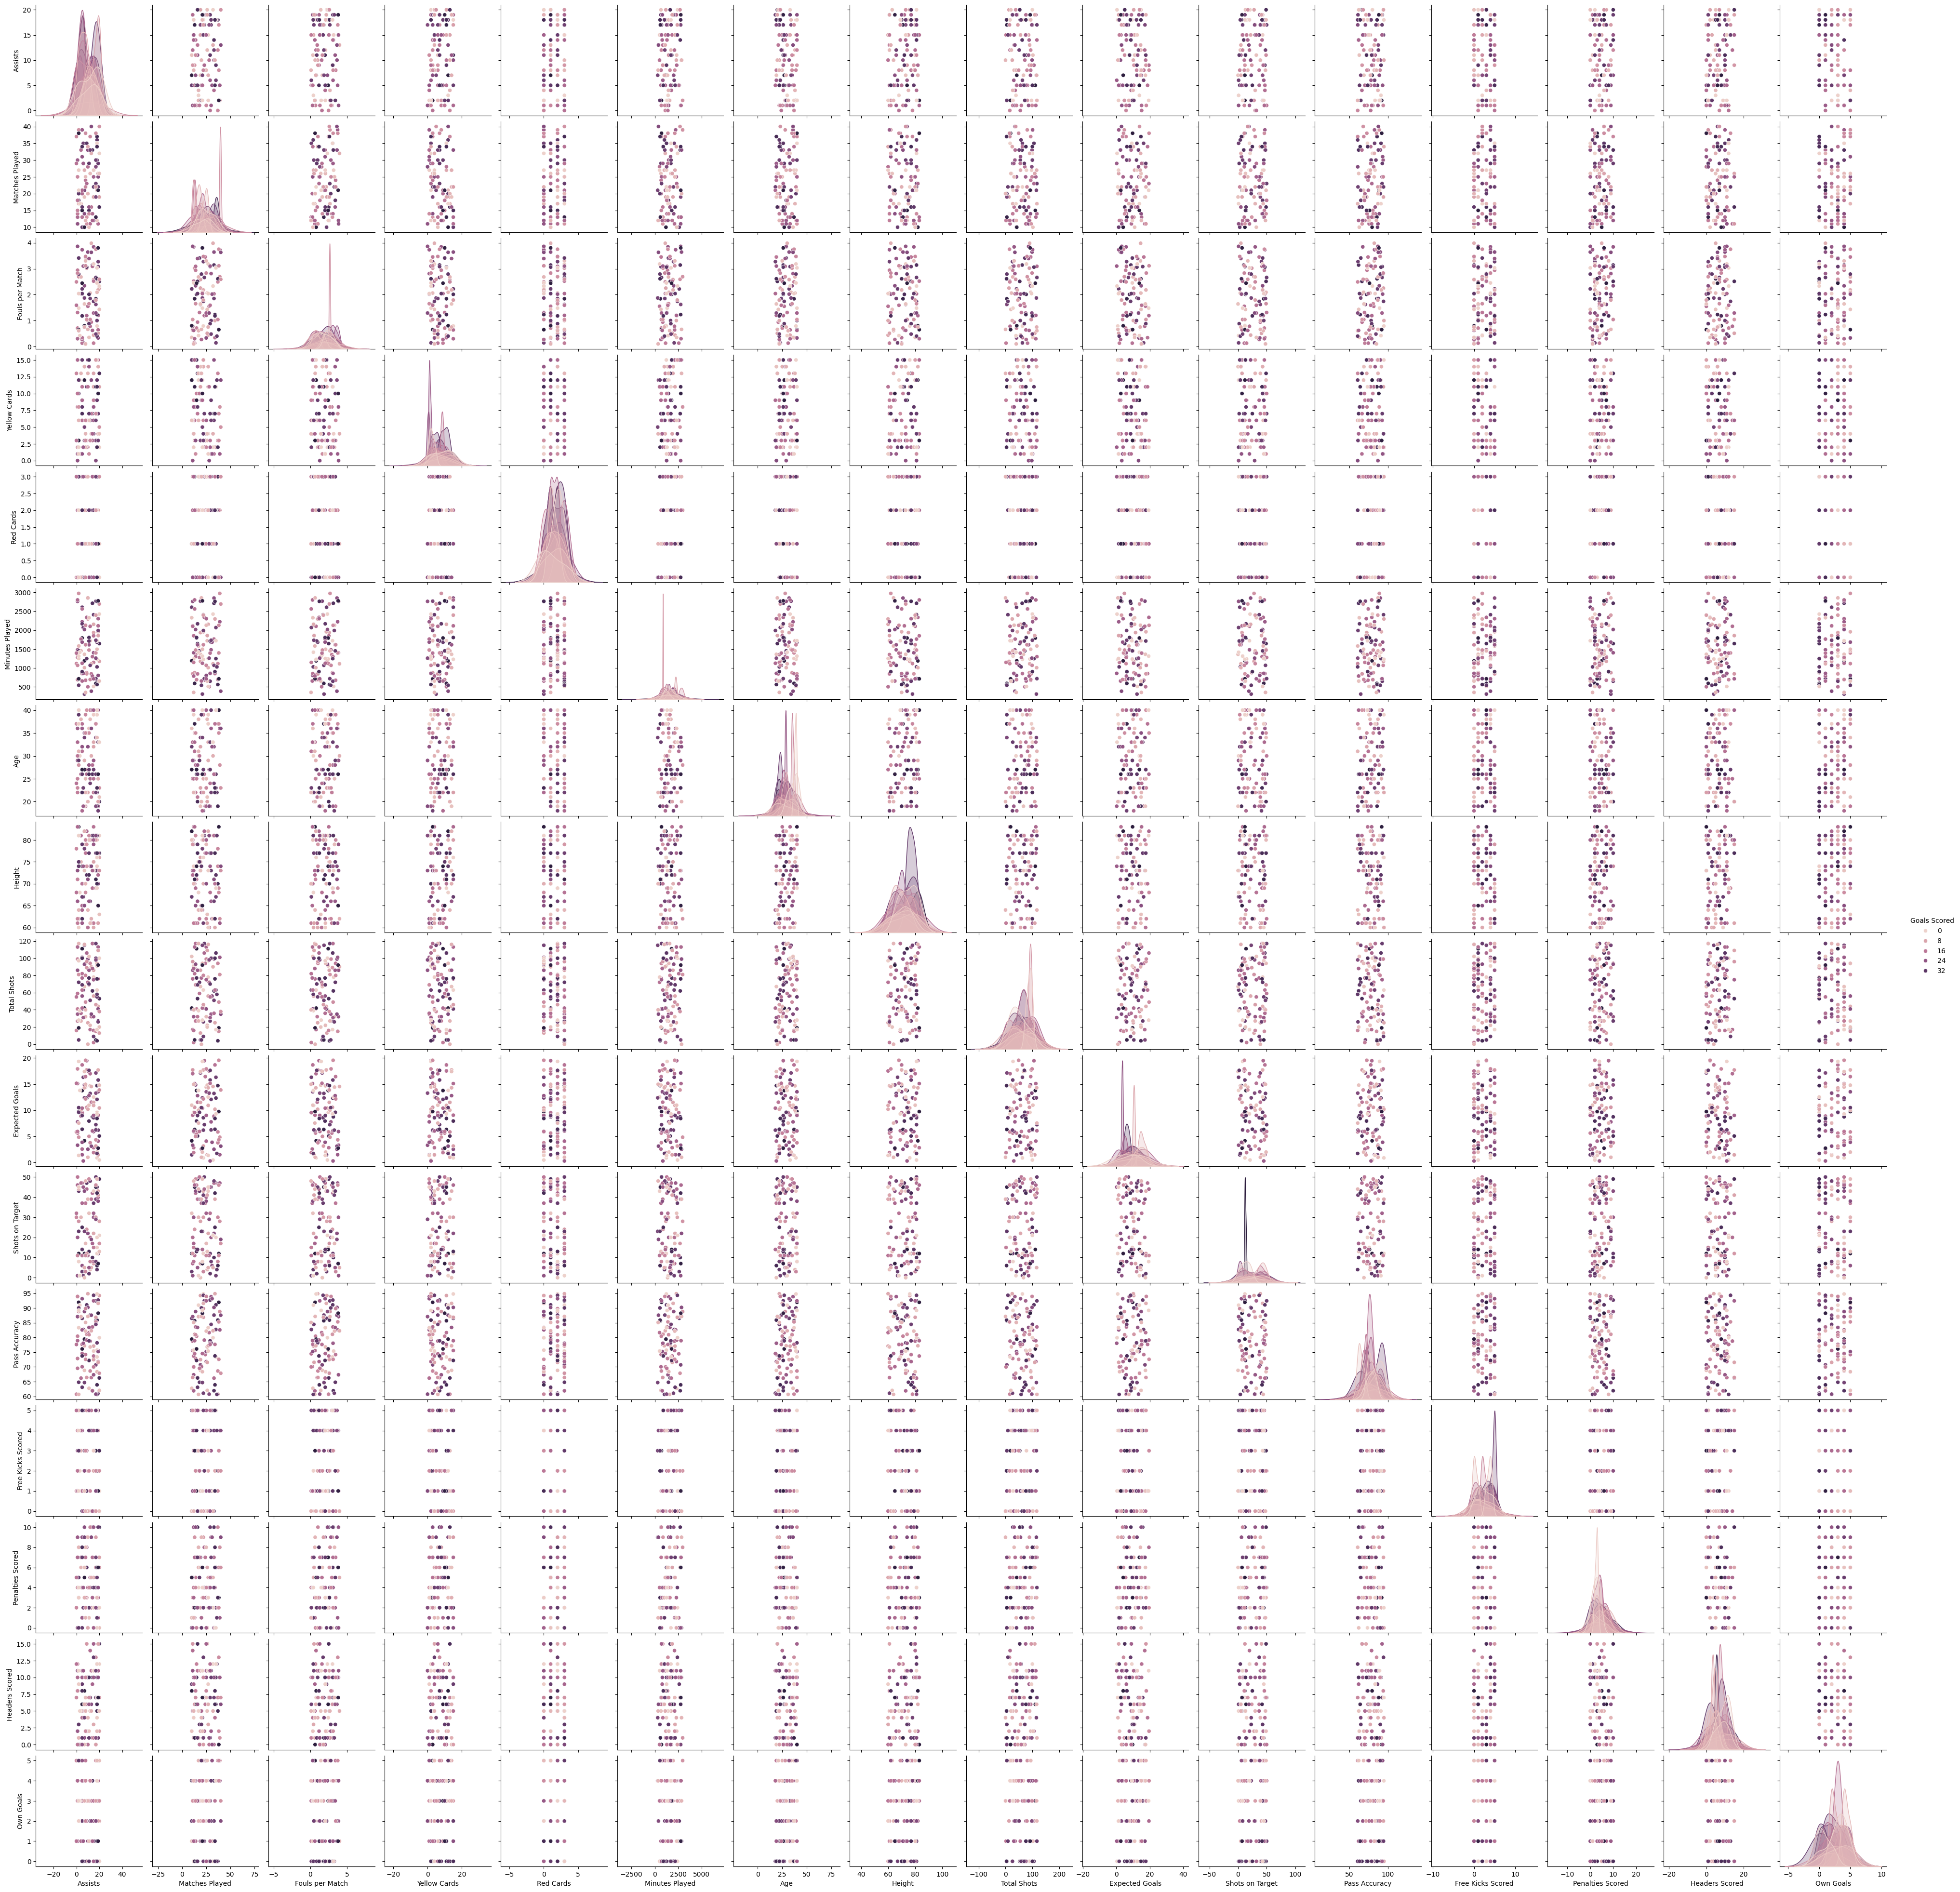

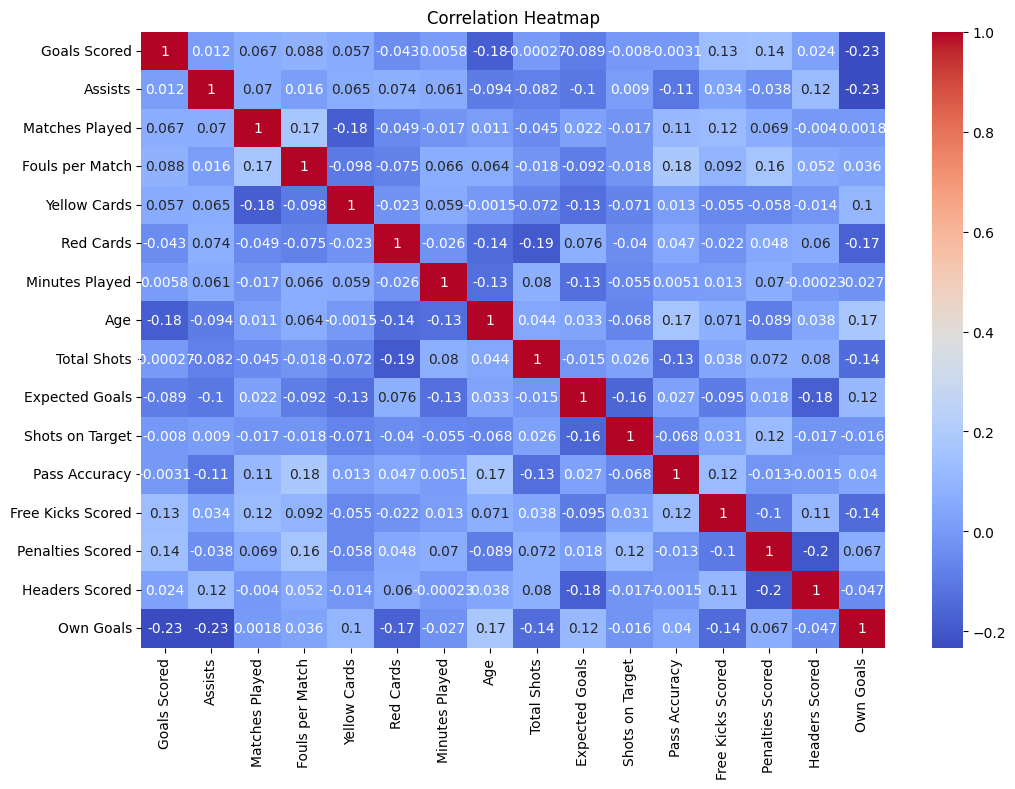

In [29]:
sns.pairplot(data, hue='Goals Scored')
plt.show()

# Correlation Heatmap
corr = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Train and test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Feature Importance

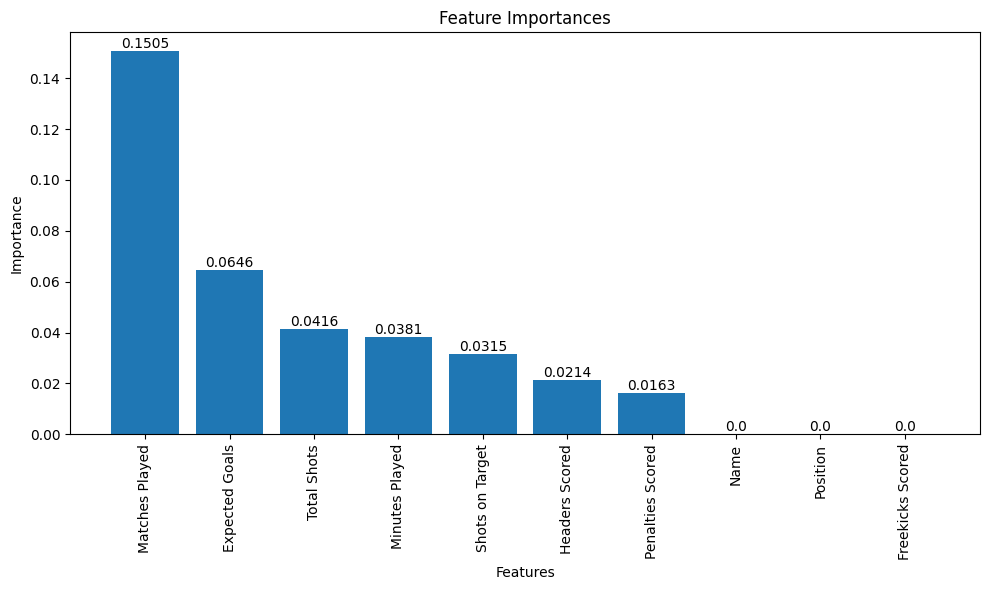

In [31]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
selected_features = ['Name', 'Position', 'Matches Played', 'Minutes Played', 'Total Shots','Expected Goals','Shots on Target', 'Freekicks Scored', 'Penalties Scored', 'Headers Scored']

# Extract feature importances for selected features
importances = model.feature_importances_
feature_names = X_final.columns

selected_importances = []
for feature in selected_features:
    if feature in feature_names:
        feature_index = np.where(feature_names == feature)[0][0]
        selected_importances.append(importances[feature_index])
    else:
        selected_importances.append(0)

selected_feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': selected_importances})

selected_feature_importances = selected_feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
bars = plt.bar(selected_feature_importances['Feature'], selected_feature_importances['Importance'])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

Model Training

Cross-Validation RMSE Scores: [ 8.84540254  6.30942945 13.68129773 11.41144567 13.59747618]
Mean Cross-Validation RMSE: 10.769010315033153


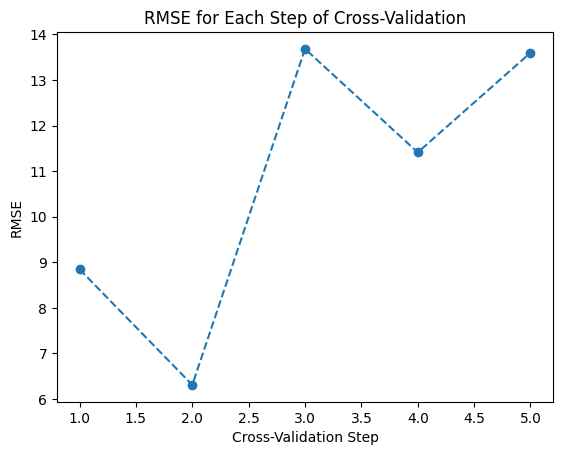

In [32]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = (-cv_scores) ** 0.5
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean Cross-Validation RMSE:", cv_rmse_scores.mean())

# Plot RMSE for each step of cross-validation
plt.plot(range(1, 6), cv_rmse_scores, marker='o', linestyle='--')
plt.xlabel('Cross-Validation Step')
plt.ylabel('RMSE')
plt.title('RMSE for Each Step of Cross-Validation')
plt.show()

Model testing

In [33]:
# Predict on the test set
y_pred_test = rf_regressor.predict(X_test)

# Calculate evaluation metrics (e.g., Mean Squared Error, Mean Absolute Error)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 168.79328000000004
Mean Absolute Error: 10.059999999999999


Train Test

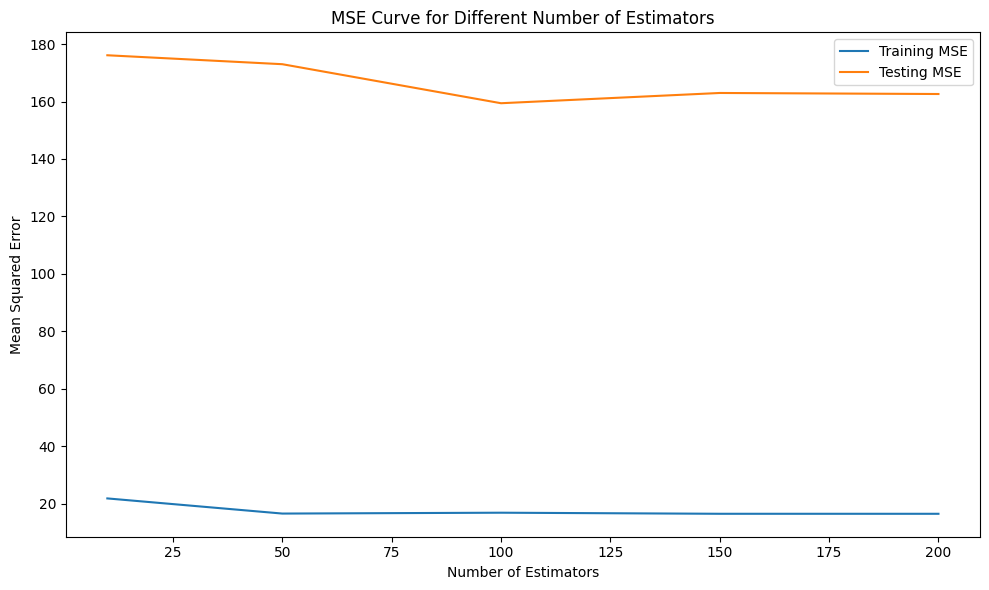

In [34]:
# Define a range of number of trees (estimators)
num_estimators = [10, 50, 100, 150, 200]

train_errors = []
test_errors = []

for n in num_estimators:
    # Train the random forest regression model
    model = RandomForestRegressor(n_estimators=n)
    model.fit(X_train, y_train)

    # Make predictions on the training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the mean squared errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    # Append the errors to the lists
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot the MSE curve
plt.figure(figsize=(10, 6))
plt.plot(num_estimators, train_errors, label='Training MSE')
plt.plot(num_estimators, test_errors, label='Testing MSE')
plt.title('MSE Curve for Different Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.tight_layout()
plt.show()




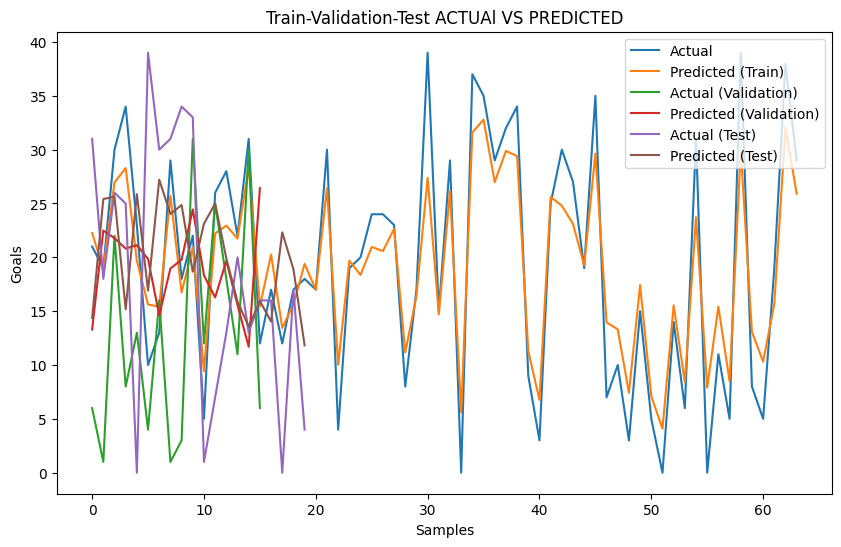

In [37]:
# Calculate the training set predictions
y_pred_train = rf_regressor.predict(X_train)

# Calculate the training set mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)

# Plot the train-test-validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_train)), y_train, label='Actual')
plt.plot(range(len(y_pred_train)), y_pred_train, label='Predicted (Train)')
plt.plot(range(len(y_val)), y_val, label='Actual (Validation)')
plt.plot(range(len(y_pred_val)), y_pred_val, label='Predicted (Validation)')
plt.plot(range(len(y_test)), y_test, label='Actual (Test)')
plt.plot(range(len(y_pred_test)), y_pred_test, label='Predicted (Test)')
plt.xlabel('Samples')
plt.ylabel('Goals')
plt.title('Train-Validation-Test ACTUAl VS PREDICTED')
plt.legend()
plt.show()


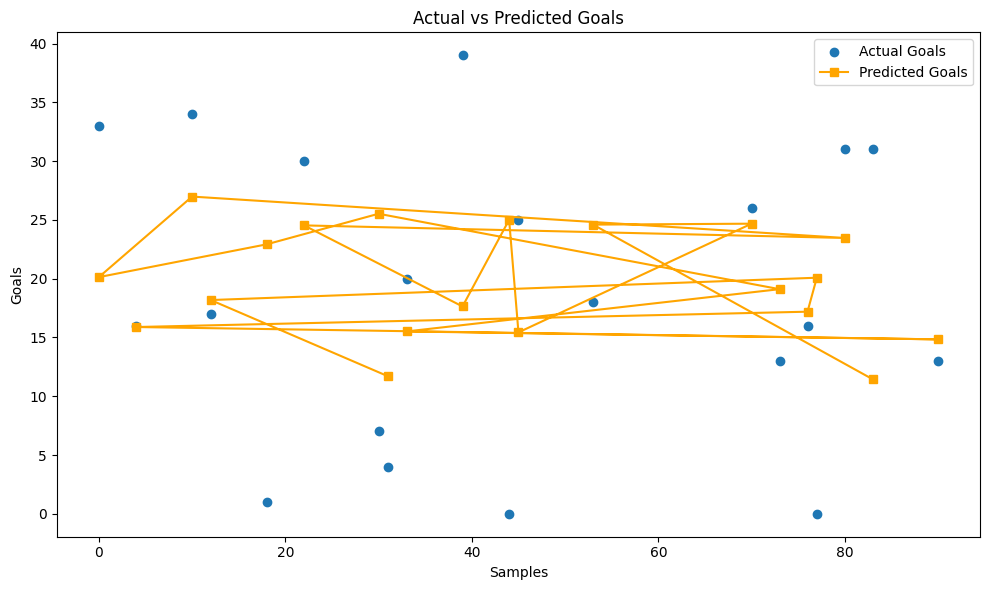

In [36]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Create a DataFrame with actual and predicted goal values
goal_comparison = pd.DataFrame({'Actual Goals': y_test, 'Predicted Goals': y_pred})

# Plot the actual versus predicted goal values
plt.figure(figsize=(10, 6))
plt.title("Actual vs Predicted Goals")
plt.scatter(goal_comparison.index, goal_comparison['Actual Goals'], label='Actual Goals', marker='o')
plt.plot(goal_comparison.index, goal_comparison['Predicted Goals'], label='Predicted Goals', linestyle='-', marker='s', color='orange')
plt.xlabel("Samples")
plt.ylabel("Goals")
plt.legend()
plt.tight_layout()
plt.show()
